##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TF Lite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TF Lite colab.


## Setup

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.1
Hub version: 0.9.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available


## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

In [3]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 4s

  8396800/228813984 [>.............................] - ETA: 18s

 21987328/228813984 [=>............................] - ETA: 7s 

 35962880/228813984 [===>..........................] - ETA: 4s

 49897472/228813984 [=====>........................] - ETA: 3s

 50339840/228813984 [=====>........................] - ETA: 4s

 64610304/228813984 [=======>......................] - ETA: 3s

 78544896/228813984 [=========>....................] - ETA: 2s

 83894272/228813984 [=========>....................] - ETA: 3s

 98017280/228813984 [===========>..................] - ETA: 2s

100671488/228813984 [============>.................] - ETA: 2s

115023872/228813984 [==============>...............] - ETA: 2s

125837312/228813984 [===============>..............] - ETA: 1s

139886592/228813984 [=================>............] - ETA: 1s

153853952/228813984 [===================>..........] - ETA: 1s

166305792/228813984 [====================>.........] - ETA: 0s

180666368/228813984 [======================>.......] - ETA: 0s

189267968/228813984 [=======================>......] - ETA: 0s

200269824/228813984 [=========================>....] - ETA: 0s

209723392/228813984 [==========================>...] - ETA: 0s

218112000/228813984 [===========================>..] - ETA: 0s

228818944/228813984 [==============================] - 3s 0us/step


In [5]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5


 1/91 [..............................] - ETA: 0s - loss: 2.1255 - accuracy: 0.1562

 3/91 [..............................] - ETA: 4s - loss: 2.1435 - accuracy: 0.1250

 4/91 [>.............................] - ETA: 6s - loss: 2.0761 - accuracy: 0.1562

 5/91 [>.............................] - ETA: 8s - loss: 1.9928 - accuracy: 0.2000

 6/91 [>.............................] - ETA: 8s - loss: 1.9261 - accuracy: 0.2396

 7/91 [=>............................] - ETA: 8s - loss: 1.9047 - accuracy: 0.2545

 8/91 [=>............................] - ETA: 8s - loss: 1.8213 - accuracy: 0.3008

 9/91 [=>............................] - ETA: 9s - loss: 1.7532 - accuracy: 0.3264

10/91 [==>...........................] - ETA: 9s - loss: 1.7031 - accuracy: 0.3562

11/91 [==>...........................] - ETA: 9s - loss: 1.6605 - accuracy: 0.3750

12/91 [==>...........................] - ETA: 9s - loss: 1.6178 - accuracy: 0.3932

13/91 [===>..........................] - ETA: 9s - loss: 1.5788 - accuracy: 0.4135

14/91 [===>..........................] - ETA: 9s - loss: 1.5342 - accuracy: 0.4330

15/91 [===>..........................] - ETA: 9s - loss: 1.5222 - accuracy: 0.4417

16/91 [====>.........................] - ETA: 9s - loss: 1.5113 - accuracy: 0.4453

17/91 [====>.........................] - ETA: 9s - loss: 1.4820 - accuracy: 0.4577

18/91 [====>.........................] - ETA: 9s - loss: 1.4537 - accuracy: 0.4740

19/91 [=====>........................] - ETA: 9s - loss: 1.4249 - accuracy: 0.4868

20/91 [=====>........................] - ETA: 8s - loss: 1.4254 - accuracy: 0.4891

21/91 [=====>........................] - ETA: 8s - loss: 1.4110 - accuracy: 0.4985

22/91 [======>.......................] - ETA: 8s - loss: 1.3893 - accuracy: 0.5099

23/91 [======>.......................] - ETA: 8s - loss: 1.3744 - accuracy: 0.5204

24/91 [======>.......................] - ETA: 8s - loss: 1.3568 - accuracy: 0.5286

25/91 [=======>......................] - ETA: 8s - loss: 1.3418 - accuracy: 0.5362

26/91 [=======>......................] - ETA: 8s - loss: 1.3242 - accuracy: 0.5445

27/91 [=======>......................] - ETA: 8s - loss: 1.3031 - accuracy: 0.5532

28/91 [========>.....................] - ETA: 7s - loss: 1.2945 - accuracy: 0.5592

29/91 [========>.....................] - ETA: 7s - loss: 1.2821 - accuracy: 0.5647

30/91 [========>.....................] - ETA: 7s - loss: 1.2774 - accuracy: 0.5698

31/91 [=========>....................] - ETA: 7s - loss: 1.2668 - accuracy: 0.5756

32/91 [=========>....................] - ETA: 7s - loss: 1.2537 - accuracy: 0.5811

33/91 [=========>....................] - ETA: 7s - loss: 1.2392 - accuracy: 0.5881

34/91 [==========>...................] - ETA: 7s - loss: 1.2259 - accuracy: 0.5956

35/91 [==========>...................] - ETA: 7s - loss: 1.2110 - accuracy: 0.6018

36/91 [==========>...................] - ETA: 7s - loss: 1.1986 - accuracy: 0.6094

37/91 [===========>..................] - ETA: 6s - loss: 1.1934 - accuracy: 0.6115

38/91 [===========>..................] - ETA: 6s - loss: 1.1892 - accuracy: 0.6143

39/91 [===========>..................] - ETA: 6s - loss: 1.1797 - accuracy: 0.6170

40/91 [============>.................] - ETA: 6s - loss: 1.1672 - accuracy: 0.6242

41/91 [============>.................] - ETA: 6s - loss: 1.1607 - accuracy: 0.6280

42/91 [============>.................] - ETA: 6s - loss: 1.1545 - accuracy: 0.6295

43/91 [=============>................] - ETA: 6s - loss: 1.1447 - accuracy: 0.6352

44/91 [=============>................] - ETA: 6s - loss: 1.1384 - accuracy: 0.6392

45/91 [=============>................] - ETA: 6s - loss: 1.1370 - accuracy: 0.6396

46/91 [==============>...............] - ETA: 5s - loss: 1.1302 - accuracy: 0.6440

47/91 [==============>...............] - ETA: 5s - loss: 1.1206 - accuracy: 0.6503

48/91 [==============>...............] - ETA: 5s - loss: 1.1137 - accuracy: 0.6556

49/91 [===============>..............] - ETA: 5s - loss: 1.1159 - accuracy: 0.6550

50/91 [===============>..............] - ETA: 5s - loss: 1.1112 - accuracy: 0.6562

51/91 [===============>..............] - ETA: 5s - loss: 1.1048 - accuracy: 0.6593

52/91 [================>.............] - ETA: 5s - loss: 1.0971 - accuracy: 0.6647

53/91 [================>.............] - ETA: 5s - loss: 1.0908 - accuracy: 0.6675

54/91 [================>.............] - ETA: 4s - loss: 1.0867 - accuracy: 0.6690

55/91 [=================>............] - ETA: 4s - loss: 1.0842 - accuracy: 0.6705

56/91 [=================>............] - ETA: 4s - loss: 1.0837 - accuracy: 0.6713

57/91 [=================>............] - ETA: 4s - loss: 1.0772 - accuracy: 0.6749

58/91 [==================>...........] - ETA: 4s - loss: 1.0717 - accuracy: 0.6778

59/91 [==================>...........] - ETA: 4s - loss: 1.0705 - accuracy: 0.6790

60/91 [==================>...........] - ETA: 4s - loss: 1.0657 - accuracy: 0.6833

61/91 [===================>..........] - ETA: 3s - loss: 1.0587 - accuracy: 0.6870

62/91 [===================>..........] - ETA: 3s - loss: 1.0602 - accuracy: 0.6860

63/91 [===================>..........] - ETA: 3s - loss: 1.0610 - accuracy: 0.6875

64/91 [====================>.........] - ETA: 3s - loss: 1.0560 - accuracy: 0.6899

65/91 [====================>.........] - ETA: 3s - loss: 1.0504 - accuracy: 0.6923

66/91 [====================>.........] - ETA: 3s - loss: 1.0457 - accuracy: 0.6946

67/91 [=====================>........] - ETA: 3s - loss: 1.0397 - accuracy: 0.6973

68/91 [=====================>........] - ETA: 3s - loss: 1.0350 - accuracy: 0.6999

69/91 [=====================>........] - ETA: 2s - loss: 1.0302 - accuracy: 0.7024

70/91 [======================>.......] - ETA: 2s - loss: 1.0245 - accuracy: 0.7049

71/91 [======================>.......] - ETA: 2s - loss: 1.0214 - accuracy: 0.7055

72/91 [======================>.......] - ETA: 2s - loss: 1.0170 - accuracy: 0.7070

73/91 [=======================>......] - ETA: 2s - loss: 1.0150 - accuracy: 0.7080

74/91 [=======================>......] - ETA: 2s - loss: 1.0129 - accuracy: 0.7086

75/91 [=======================>......] - ETA: 2s - loss: 1.0099 - accuracy: 0.7100

76/91 [========================>.....] - ETA: 1s - loss: 1.0088 - accuracy: 0.7103

77/91 [========================>.....] - ETA: 1s - loss: 1.0063 - accuracy: 0.7113

78/91 [========================>.....] - ETA: 1s - loss: 1.0010 - accuracy: 0.7146

79/91 [=========================>....] - ETA: 1s - loss: 0.9968 - accuracy: 0.7162

80/91 [=========================>....] - ETA: 1s - loss: 0.9950 - accuracy: 0.7170

81/91 [=========================>....] - ETA: 1s - loss: 0.9929 - accuracy: 0.7190

82/91 [==========================>...] - ETA: 1s - loss: 0.9892 - accuracy: 0.7209

83/91 [==========================>...] - ETA: 1s - loss: 0.9880 - accuracy: 0.7216

84/91 [==========================>...] - ETA: 0s - loss: 0.9846 - accuracy: 0.7234

85/91 [===========================>..] - ETA: 0s - loss: 0.9848 - accuracy: 0.7227

86/91 [===========================>..] - ETA: 0s - loss: 0.9808 - accuracy: 0.7252

87/91 [===========================>..] - ETA: 0s - loss: 0.9787 - accuracy: 0.7262

88/91 [============================>.] - ETA: 0s - loss: 0.9769 - accuracy: 0.7275

89/91 [============================>.] - ETA: 0s - loss: 0.9771 - accuracy: 0.7274

90/91 [============================>.] - ETA: 0s - loss: 0.9758 - accuracy: 0.7273

91/91 [==============================] - ETA: 0s - loss: 0.9733 - accuracy: 0.7286

91/91 [==============================] - 16s 171ms/step - loss: 0.9733 - accuracy: 0.7286 - val_loss: 0.7463 - val_accuracy: 0.8395


Epoch 2/5
 1/91 [..............................] - ETA: 0s - loss: 0.7815 - accuracy: 0.8750

 2/91 [..............................] - ETA: 6s - loss: 0.7832 - accuracy: 0.8438

 3/91 [..............................] - ETA: 8s - loss: 0.7751 - accuracy: 0.8438

 4/91 [>.............................] - ETA: 8s - loss: 0.7824 - accuracy: 0.8359

 5/91 [>.............................] - ETA: 9s - loss: 0.7524 - accuracy: 0.8625

 6/91 [>.............................] - ETA: 9s - loss: 0.7309 - accuracy: 0.8698

 7/91 [=>............................] - ETA: 9s - loss: 0.7287 - accuracy: 0.8705

 8/91 [=>............................] - ETA: 9s - loss: 0.7388 - accuracy: 0.8594

 9/91 [=>............................] - ETA: 9s - loss: 0.7329 - accuracy: 0.8681

10/91 [==>...........................] - ETA: 9s - loss: 0.7176 - accuracy: 0.8750

11/91 [==>...........................] - ETA: 9s - loss: 0.7219 - accuracy: 0.8778

12/91 [==>...........................] - ETA: 9s - loss: 0.7210 - accuracy: 0.8776

13/91 [===>..........................] - ETA: 9s - loss: 0.7180 - accuracy: 0.8774

14/91 [===>..........................] - ETA: 9s - loss: 0.7184 - accuracy: 0.8750

15/91 [===>..........................] - ETA: 9s - loss: 0.7121 - accuracy: 0.8771

16/91 [====>.........................] - ETA: 9s - loss: 0.7087 - accuracy: 0.8770

17/91 [====>.........................] - ETA: 9s - loss: 0.7025 - accuracy: 0.8824

18/91 [====>.........................] - ETA: 8s - loss: 0.7002 - accuracy: 0.8837

19/91 [=====>........................] - ETA: 8s - loss: 0.6980 - accuracy: 0.8832

20/91 [=====>........................] - ETA: 8s - loss: 0.7053 - accuracy: 0.8797

21/91 [=====>........................] - ETA: 8s - loss: 0.7052 - accuracy: 0.8795

22/91 [======>.......................] - ETA: 8s - loss: 0.7041 - accuracy: 0.8793

23/91 [======>.......................] - ETA: 8s - loss: 0.7039 - accuracy: 0.8750

24/91 [======>.......................] - ETA: 8s - loss: 0.7067 - accuracy: 0.8711

25/91 [=======>......................] - ETA: 8s - loss: 0.7093 - accuracy: 0.8687

26/91 [=======>......................] - ETA: 7s - loss: 0.7073 - accuracy: 0.8702

27/91 [=======>......................] - ETA: 7s - loss: 0.7039 - accuracy: 0.8715

28/91 [========>.....................] - ETA: 7s - loss: 0.6985 - accuracy: 0.8750

29/91 [========>.....................] - ETA: 7s - loss: 0.6978 - accuracy: 0.8750

30/91 [========>.....................] - ETA: 7s - loss: 0.6938 - accuracy: 0.8771

31/91 [=========>....................] - ETA: 7s - loss: 0.6942 - accuracy: 0.8780

32/91 [=========>....................] - ETA: 7s - loss: 0.6901 - accuracy: 0.8809

33/91 [=========>....................] - ETA: 7s - loss: 0.6903 - accuracy: 0.8807

34/91 [==========>...................] - ETA: 7s - loss: 0.6879 - accuracy: 0.8814

35/91 [==========>...................] - ETA: 6s - loss: 0.6861 - accuracy: 0.8821

36/91 [==========>...................] - ETA: 6s - loss: 0.6860 - accuracy: 0.8819

37/91 [===========>..................] - ETA: 6s - loss: 0.6842 - accuracy: 0.8818

38/91 [===========>..................] - ETA: 6s - loss: 0.6845 - accuracy: 0.8808

39/91 [===========>..................] - ETA: 6s - loss: 0.6829 - accuracy: 0.8814

40/91 [============>.................] - ETA: 6s - loss: 0.6846 - accuracy: 0.8820

41/91 [============>.................] - ETA: 6s - loss: 0.6854 - accuracy: 0.8826

42/91 [============>.................] - ETA: 6s - loss: 0.6878 - accuracy: 0.8802

43/91 [=============>................] - ETA: 5s - loss: 0.6883 - accuracy: 0.8801

44/91 [=============>................] - ETA: 5s - loss: 0.6895 - accuracy: 0.8778

45/91 [=============>................] - ETA: 5s - loss: 0.6901 - accuracy: 0.8778

46/91 [==============>...............] - ETA: 5s - loss: 0.6895 - accuracy: 0.8787

47/91 [==============>...............] - ETA: 5s - loss: 0.6874 - accuracy: 0.8806

48/91 [==============>...............] - ETA: 5s - loss: 0.6916 - accuracy: 0.8785

49/91 [===============>..............] - ETA: 5s - loss: 0.6917 - accuracy: 0.8791

50/91 [===============>..............] - ETA: 5s - loss: 0.6938 - accuracy: 0.8784

51/91 [===============>..............] - ETA: 5s - loss: 0.6929 - accuracy: 0.8789

52/91 [================>.............] - ETA: 4s - loss: 0.6919 - accuracy: 0.8800

53/91 [================>.............] - ETA: 4s - loss: 0.6925 - accuracy: 0.8800

54/91 [================>.............] - ETA: 4s - loss: 0.6922 - accuracy: 0.8793

55/91 [=================>............] - ETA: 4s - loss: 0.6932 - accuracy: 0.8781

56/91 [=================>............] - ETA: 4s - loss: 0.6967 - accuracy: 0.8774

57/91 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.8780

58/91 [==================>...........] - ETA: 4s - loss: 0.6985 - accuracy: 0.8741

59/91 [==================>...........] - ETA: 4s - loss: 0.6962 - accuracy: 0.8757

60/91 [==================>...........] - ETA: 3s - loss: 0.6952 - accuracy: 0.8768

61/91 [===================>..........] - ETA: 3s - loss: 0.6977 - accuracy: 0.8747

62/91 [===================>..........] - ETA: 3s - loss: 0.6994 - accuracy: 0.8732

63/91 [===================>..........] - ETA: 3s - loss: 0.7018 - accuracy: 0.8722

64/91 [====================>.........] - ETA: 3s - loss: 0.7002 - accuracy: 0.8732

65/91 [====================>.........] - ETA: 3s - loss: 0.6982 - accuracy: 0.8742

66/91 [====================>.........] - ETA: 3s - loss: 0.6984 - accuracy: 0.8742

67/91 [=====================>........] - ETA: 3s - loss: 0.6978 - accuracy: 0.8738

68/91 [=====================>........] - ETA: 2s - loss: 0.6988 - accuracy: 0.8733

69/91 [=====================>........] - ETA: 2s - loss: 0.6970 - accuracy: 0.8743

70/91 [======================>.......] - ETA: 2s - loss: 0.6978 - accuracy: 0.8752

71/91 [======================>.......] - ETA: 2s - loss: 0.6980 - accuracy: 0.8743

72/91 [======================>.......] - ETA: 2s - loss: 0.6968 - accuracy: 0.8743

73/91 [=======================>......] - ETA: 2s - loss: 0.6970 - accuracy: 0.8747

74/91 [=======================>......] - ETA: 2s - loss: 0.6976 - accuracy: 0.8743

75/91 [=======================>......] - ETA: 2s - loss: 0.6978 - accuracy: 0.8743

76/91 [========================>.....] - ETA: 1s - loss: 0.6980 - accuracy: 0.8747

77/91 [========================>.....] - ETA: 1s - loss: 0.6995 - accuracy: 0.8743

78/91 [========================>.....] - ETA: 1s - loss: 0.6986 - accuracy: 0.8743

79/91 [=========================>....] - ETA: 1s - loss: 0.7003 - accuracy: 0.8728

80/91 [=========================>....] - ETA: 1s - loss: 0.6993 - accuracy: 0.8736

81/91 [=========================>....] - ETA: 1s - loss: 0.6982 - accuracy: 0.8740

82/91 [==========================>...] - ETA: 1s - loss: 0.7004 - accuracy: 0.8732

83/91 [==========================>...] - ETA: 1s - loss: 0.7001 - accuracy: 0.8733

84/91 [==========================>...] - ETA: 0s - loss: 0.6987 - accuracy: 0.8740

85/91 [===========================>..] - ETA: 0s - loss: 0.6985 - accuracy: 0.8744

86/91 [===========================>..] - ETA: 0s - loss: 0.6981 - accuracy: 0.8751

87/91 [===========================>..] - ETA: 0s - loss: 0.6970 - accuracy: 0.8759

88/91 [============================>.] - ETA: 0s - loss: 0.6962 - accuracy: 0.8758

89/91 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.8765

90/91 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.8769

91/91 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.8762

91/91 [==============================] - 15s 160ms/step - loss: 0.6944 - accuracy: 0.8762 - val_loss: 0.7031 - val_accuracy: 0.8665


Epoch 3/5
 1/91 [..............................] - ETA: 0s - loss: 0.5868 - accuracy: 0.9375

 2/91 [..............................] - ETA: 6s - loss: 0.6273 - accuracy: 0.9219

 3/91 [..............................] - ETA: 7s - loss: 0.6703 - accuracy: 0.9062

 4/91 [>.............................] - ETA: 8s - loss: 0.6509 - accuracy: 0.9297

 5/91 [>.............................] - ETA: 9s - loss: 0.6689 - accuracy: 0.8938

 6/91 [>.............................] - ETA: 9s - loss: 0.6631 - accuracy: 0.8958

 7/91 [=>............................] - ETA: 9s - loss: 0.6691 - accuracy: 0.8973

 8/91 [=>............................] - ETA: 9s - loss: 0.6567 - accuracy: 0.9062

 9/91 [=>............................] - ETA: 9s - loss: 0.6577 - accuracy: 0.9028

10/91 [==>...........................] - ETA: 9s - loss: 0.6518 - accuracy: 0.9062

11/91 [==>...........................] - ETA: 9s - loss: 0.6478 - accuracy: 0.9091

12/91 [==>...........................] - ETA: 9s - loss: 0.6510 - accuracy: 0.9010

13/91 [===>..........................] - ETA: 9s - loss: 0.6461 - accuracy: 0.9062

14/91 [===>..........................] - ETA: 9s - loss: 0.6509 - accuracy: 0.8996

15/91 [===>..........................] - ETA: 9s - loss: 0.6515 - accuracy: 0.8938

16/91 [====>.........................] - ETA: 9s - loss: 0.6458 - accuracy: 0.8984

17/91 [====>.........................] - ETA: 9s - loss: 0.6446 - accuracy: 0.8989

18/91 [====>.........................] - ETA: 8s - loss: 0.6442 - accuracy: 0.9010

19/91 [=====>........................] - ETA: 8s - loss: 0.6452 - accuracy: 0.9013

20/91 [=====>........................] - ETA: 8s - loss: 0.6464 - accuracy: 0.9016

21/91 [=====>........................] - ETA: 8s - loss: 0.6439 - accuracy: 0.9018

22/91 [======>.......................] - ETA: 8s - loss: 0.6441 - accuracy: 0.8991

23/91 [======>.......................] - ETA: 8s - loss: 0.6424 - accuracy: 0.8981

24/91 [======>.......................] - ETA: 8s - loss: 0.6394 - accuracy: 0.8984

25/91 [=======>......................] - ETA: 8s - loss: 0.6420 - accuracy: 0.8975

26/91 [=======>......................] - ETA: 8s - loss: 0.6377 - accuracy: 0.9014

27/91 [=======>......................] - ETA: 7s - loss: 0.6379 - accuracy: 0.9005

28/91 [========>.....................] - ETA: 7s - loss: 0.6403 - accuracy: 0.8996

29/91 [========>.....................] - ETA: 7s - loss: 0.6401 - accuracy: 0.8987

30/91 [========>.....................] - ETA: 7s - loss: 0.6411 - accuracy: 0.8979

31/91 [=========>....................] - ETA: 7s - loss: 0.6405 - accuracy: 0.8982

32/91 [=========>....................] - ETA: 7s - loss: 0.6421 - accuracy: 0.8975

33/91 [=========>....................] - ETA: 7s - loss: 0.6437 - accuracy: 0.8977

34/91 [==========>...................] - ETA: 7s - loss: 0.6473 - accuracy: 0.8971

35/91 [==========>...................] - ETA: 7s - loss: 0.6455 - accuracy: 0.8982

36/91 [==========>...................] - ETA: 6s - loss: 0.6461 - accuracy: 0.8967

37/91 [===========>..................] - ETA: 6s - loss: 0.6513 - accuracy: 0.8944

38/91 [===========>..................] - ETA: 6s - loss: 0.6523 - accuracy: 0.8939

39/91 [===========>..................] - ETA: 6s - loss: 0.6527 - accuracy: 0.8934

40/91 [============>.................] - ETA: 6s - loss: 0.6572 - accuracy: 0.8891

41/91 [============>.................] - ETA: 6s - loss: 0.6538 - accuracy: 0.8918

42/91 [============>.................] - ETA: 6s - loss: 0.6529 - accuracy: 0.8929

43/91 [=============>................] - ETA: 6s - loss: 0.6548 - accuracy: 0.8924

44/91 [=============>................] - ETA: 5s - loss: 0.6525 - accuracy: 0.8935

45/91 [=============>................] - ETA: 5s - loss: 0.6534 - accuracy: 0.8938

46/91 [==============>...............] - ETA: 5s - loss: 0.6576 - accuracy: 0.8899

47/91 [==============>...............] - ETA: 5s - loss: 0.6552 - accuracy: 0.8916

48/91 [==============>...............] - ETA: 5s - loss: 0.6564 - accuracy: 0.8919

49/91 [===============>..............] - ETA: 5s - loss: 0.6595 - accuracy: 0.8909

50/91 [===============>..............] - ETA: 5s - loss: 0.6598 - accuracy: 0.8900

51/91 [===============>..............] - ETA: 5s - loss: 0.6609 - accuracy: 0.8903

52/91 [================>.............] - ETA: 4s - loss: 0.6612 - accuracy: 0.8888

53/91 [================>.............] - ETA: 4s - loss: 0.6640 - accuracy: 0.8892

54/91 [================>.............] - ETA: 4s - loss: 0.6653 - accuracy: 0.8895

55/91 [=================>............] - ETA: 4s - loss: 0.6645 - accuracy: 0.8898

56/91 [=================>............] - ETA: 4s - loss: 0.6644 - accuracy: 0.8901

57/91 [=================>............] - ETA: 4s - loss: 0.6638 - accuracy: 0.8914

58/91 [==================>...........] - ETA: 4s - loss: 0.6627 - accuracy: 0.8922

59/91 [==================>...........] - ETA: 4s - loss: 0.6631 - accuracy: 0.8925

60/91 [==================>...........] - ETA: 3s - loss: 0.6640 - accuracy: 0.8922

61/91 [===================>..........] - ETA: 3s - loss: 0.6646 - accuracy: 0.8914

62/91 [===================>..........] - ETA: 3s - loss: 0.6636 - accuracy: 0.8911

63/91 [===================>..........] - ETA: 3s - loss: 0.6640 - accuracy: 0.8899

64/91 [====================>.........] - ETA: 3s - loss: 0.6611 - accuracy: 0.8916

65/91 [====================>.........] - ETA: 3s - loss: 0.6601 - accuracy: 0.8913

66/91 [====================>.........] - ETA: 3s - loss: 0.6601 - accuracy: 0.8916

67/91 [=====================>........] - ETA: 3s - loss: 0.6599 - accuracy: 0.8923

68/91 [=====================>........] - ETA: 2s - loss: 0.6600 - accuracy: 0.8925

69/91 [=====================>........] - ETA: 2s - loss: 0.6612 - accuracy: 0.8922

70/91 [======================>.......] - ETA: 2s - loss: 0.6603 - accuracy: 0.8924

71/91 [======================>.......] - ETA: 2s - loss: 0.6586 - accuracy: 0.8937

72/91 [======================>.......] - ETA: 2s - loss: 0.6576 - accuracy: 0.8939

73/91 [=======================>......] - ETA: 2s - loss: 0.6606 - accuracy: 0.8932

74/91 [=======================>......] - ETA: 2s - loss: 0.6588 - accuracy: 0.8942

75/91 [=======================>......] - ETA: 2s - loss: 0.6599 - accuracy: 0.8944

76/91 [========================>.....] - ETA: 1s - loss: 0.6599 - accuracy: 0.8945

77/91 [========================>.....] - ETA: 1s - loss: 0.6581 - accuracy: 0.8959

78/91 [========================>.....] - ETA: 1s - loss: 0.6585 - accuracy: 0.8960

79/91 [=========================>....] - ETA: 1s - loss: 0.6579 - accuracy: 0.8962

80/91 [=========================>....] - ETA: 1s - loss: 0.6593 - accuracy: 0.8951

81/91 [=========================>....] - ETA: 1s - loss: 0.6597 - accuracy: 0.8941

82/91 [==========================>...] - ETA: 1s - loss: 0.6590 - accuracy: 0.8946

83/91 [==========================>...] - ETA: 1s - loss: 0.6590 - accuracy: 0.8944

84/91 [==========================>...] - ETA: 0s - loss: 0.6585 - accuracy: 0.8945

85/91 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.8947

86/91 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.8948

87/91 [===========================>..] - ETA: 0s - loss: 0.6600 - accuracy: 0.8942

88/91 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.8940

89/91 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.8938

90/91 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.8932

91/91 [==============================] - ETA: 0s - loss: 0.6602 - accuracy: 0.8934

91/91 [==============================] - 14s 159ms/step - loss: 0.6602 - accuracy: 0.8934 - val_loss: 0.7243 - val_accuracy: 0.8580


Epoch 4/5
 1/91 [..............................] - ETA: 0s - loss: 0.6185 - accuracy: 0.9062

 2/91 [..............................] - ETA: 5s - loss: 0.6452 - accuracy: 0.9062

 3/91 [..............................] - ETA: 7s - loss: 0.6486 - accuracy: 0.8958

 4/91 [>.............................] - ETA: 8s - loss: 0.6499 - accuracy: 0.8828

 5/91 [>.............................] - ETA: 8s - loss: 0.6576 - accuracy: 0.8687

 6/91 [>.............................] - ETA: 8s - loss: 0.6797 - accuracy: 0.8698

 7/91 [=>............................] - ETA: 9s - loss: 0.6655 - accuracy: 0.8705

 8/91 [=>............................] - ETA: 9s - loss: 0.6672 - accuracy: 0.8711

 9/91 [=>............................] - ETA: 9s - loss: 0.6660 - accuracy: 0.8715

10/91 [==>...........................] - ETA: 9s - loss: 0.6643 - accuracy: 0.8687

11/91 [==>...........................] - ETA: 9s - loss: 0.6593 - accuracy: 0.8778

12/91 [==>...........................] - ETA: 9s - loss: 0.6705 - accuracy: 0.8724

13/91 [===>..........................] - ETA: 9s - loss: 0.6633 - accuracy: 0.8798

14/91 [===>..........................] - ETA: 9s - loss: 0.6576 - accuracy: 0.8862

15/91 [===>..........................] - ETA: 9s - loss: 0.6535 - accuracy: 0.8854

16/91 [====>.........................] - ETA: 9s - loss: 0.6537 - accuracy: 0.8848

17/91 [====>.........................] - ETA: 9s - loss: 0.6489 - accuracy: 0.8879

18/91 [====>.........................] - ETA: 9s - loss: 0.6458 - accuracy: 0.8889

19/91 [=====>........................] - ETA: 8s - loss: 0.6460 - accuracy: 0.8898

20/91 [=====>........................] - ETA: 8s - loss: 0.6411 - accuracy: 0.8938

21/91 [=====>........................] - ETA: 8s - loss: 0.6419 - accuracy: 0.8929

22/91 [======>.......................] - ETA: 8s - loss: 0.6386 - accuracy: 0.8935

23/91 [======>.......................] - ETA: 8s - loss: 0.6363 - accuracy: 0.8967

24/91 [======>.......................] - ETA: 8s - loss: 0.6345 - accuracy: 0.8971

25/91 [=======>......................] - ETA: 8s - loss: 0.6317 - accuracy: 0.9000

26/91 [=======>......................] - ETA: 8s - loss: 0.6322 - accuracy: 0.9002

27/91 [=======>......................] - ETA: 8s - loss: 0.6302 - accuracy: 0.9028

28/91 [========>.....................] - ETA: 7s - loss: 0.6296 - accuracy: 0.9029

29/91 [========>.....................] - ETA: 7s - loss: 0.6298 - accuracy: 0.9041

30/91 [========>.....................] - ETA: 7s - loss: 0.6276 - accuracy: 0.9052

31/91 [=========>....................] - ETA: 7s - loss: 0.6245 - accuracy: 0.9073

32/91 [=========>....................] - ETA: 7s - loss: 0.6260 - accuracy: 0.9053

33/91 [=========>....................] - ETA: 7s - loss: 0.6240 - accuracy: 0.9062

34/91 [==========>...................] - ETA: 7s - loss: 0.6284 - accuracy: 0.9053

35/91 [==========>...................] - ETA: 7s - loss: 0.6257 - accuracy: 0.9071

36/91 [==========>...................] - ETA: 6s - loss: 0.6305 - accuracy: 0.9045

37/91 [===========>..................] - ETA: 6s - loss: 0.6296 - accuracy: 0.9054

38/91 [===========>..................] - ETA: 6s - loss: 0.6274 - accuracy: 0.9071

39/91 [===========>..................] - ETA: 6s - loss: 0.6272 - accuracy: 0.9087

40/91 [============>.................] - ETA: 6s - loss: 0.6302 - accuracy: 0.9094

41/91 [============>.................] - ETA: 6s - loss: 0.6294 - accuracy: 0.9108

42/91 [============>.................] - ETA: 6s - loss: 0.6303 - accuracy: 0.9107

43/91 [=============>................] - ETA: 6s - loss: 0.6326 - accuracy: 0.9099

44/91 [=============>................] - ETA: 5s - loss: 0.6322 - accuracy: 0.9105

45/91 [=============>................] - ETA: 5s - loss: 0.6330 - accuracy: 0.9097

46/91 [==============>...............] - ETA: 5s - loss: 0.6326 - accuracy: 0.9110

47/91 [==============>...............] - ETA: 5s - loss: 0.6305 - accuracy: 0.9129

48/91 [==============>...............] - ETA: 5s - loss: 0.6296 - accuracy: 0.9134

49/91 [===============>..............] - ETA: 5s - loss: 0.6291 - accuracy: 0.9133

50/91 [===============>..............] - ETA: 5s - loss: 0.6287 - accuracy: 0.9131

51/91 [===============>..............] - ETA: 5s - loss: 0.6271 - accuracy: 0.9142

52/91 [================>.............] - ETA: 4s - loss: 0.6323 - accuracy: 0.9129

53/91 [================>.............] - ETA: 4s - loss: 0.6308 - accuracy: 0.9139

54/91 [================>.............] - ETA: 4s - loss: 0.6316 - accuracy: 0.9144

55/91 [=================>............] - ETA: 4s - loss: 0.6314 - accuracy: 0.9142

56/91 [=================>............] - ETA: 4s - loss: 0.6319 - accuracy: 0.9141

57/91 [=================>............] - ETA: 4s - loss: 0.6312 - accuracy: 0.9139

58/91 [==================>...........] - ETA: 4s - loss: 0.6295 - accuracy: 0.9154

59/91 [==================>...........] - ETA: 4s - loss: 0.6287 - accuracy: 0.9153

60/91 [==================>...........] - ETA: 4s - loss: 0.6292 - accuracy: 0.9144

61/91 [===================>..........] - ETA: 3s - loss: 0.6281 - accuracy: 0.9147

62/91 [===================>..........] - ETA: 3s - loss: 0.6265 - accuracy: 0.9151

63/91 [===================>..........] - ETA: 3s - loss: 0.6283 - accuracy: 0.9145

64/91 [====================>.........] - ETA: 3s - loss: 0.6288 - accuracy: 0.9139

65/91 [====================>.........] - ETA: 3s - loss: 0.6300 - accuracy: 0.9133

66/91 [====================>.........] - ETA: 3s - loss: 0.6305 - accuracy: 0.9136

67/91 [=====================>........] - ETA: 3s - loss: 0.6290 - accuracy: 0.9144

68/91 [=====================>........] - ETA: 2s - loss: 0.6281 - accuracy: 0.9152

69/91 [=====================>........] - ETA: 2s - loss: 0.6291 - accuracy: 0.9142

70/91 [======================>.......] - ETA: 2s - loss: 0.6295 - accuracy: 0.9132

71/91 [======================>.......] - ETA: 2s - loss: 0.6306 - accuracy: 0.9127

72/91 [======================>.......] - ETA: 2s - loss: 0.6312 - accuracy: 0.9126

73/91 [=======================>......] - ETA: 2s - loss: 0.6297 - accuracy: 0.9133

74/91 [=======================>......] - ETA: 2s - loss: 0.6309 - accuracy: 0.9132

75/91 [=======================>......] - ETA: 2s - loss: 0.6307 - accuracy: 0.9136

76/91 [========================>.....] - ETA: 1s - loss: 0.6309 - accuracy: 0.9135

77/91 [========================>.....] - ETA: 1s - loss: 0.6300 - accuracy: 0.9134

78/91 [========================>.....] - ETA: 1s - loss: 0.6304 - accuracy: 0.9129

79/91 [=========================>....] - ETA: 1s - loss: 0.6294 - accuracy: 0.9136

80/91 [=========================>....] - ETA: 1s - loss: 0.6286 - accuracy: 0.9139

81/91 [=========================>....] - ETA: 1s - loss: 0.6293 - accuracy: 0.9138

82/91 [==========================>...] - ETA: 1s - loss: 0.6303 - accuracy: 0.9137

83/91 [==========================>...] - ETA: 1s - loss: 0.6298 - accuracy: 0.9136

84/91 [==========================>...] - ETA: 0s - loss: 0.6296 - accuracy: 0.9139

85/91 [===========================>..] - ETA: 0s - loss: 0.6307 - accuracy: 0.9131

86/91 [===========================>..] - ETA: 0s - loss: 0.6296 - accuracy: 0.9137

87/91 [===========================>..] - ETA: 0s - loss: 0.6306 - accuracy: 0.9133

88/91 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.9136

89/91 [============================>.] - ETA: 0s - loss: 0.6288 - accuracy: 0.9142

90/91 [============================>.] - ETA: 0s - loss: 0.6279 - accuracy: 0.9148

91/91 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.9143

91/91 [==============================] - 15s 162ms/step - loss: 0.6276 - accuracy: 0.9143 - val_loss: 0.7081 - val_accuracy: 0.8665


Epoch 5/5
 1/91 [..............................] - ETA: 0s - loss: 0.5157 - accuracy: 1.0000

 2/91 [..............................] - ETA: 4s - loss: 0.5464 - accuracy: 0.9688

 3/91 [..............................] - ETA: 6s - loss: 0.5774 - accuracy: 0.9479

 4/91 [>.............................] - ETA: 7s - loss: 0.5608 - accuracy: 0.9453

 5/91 [>.............................] - ETA: 8s - loss: 0.5491 - accuracy: 0.9563

 6/91 [>.............................] - ETA: 8s - loss: 0.5510 - accuracy: 0.9583

 7/91 [=>............................] - ETA: 8s - loss: 0.5406 - accuracy: 0.9643

 8/91 [=>............................] - ETA: 8s - loss: 0.5401 - accuracy: 0.9688

 9/91 [=>............................] - ETA: 9s - loss: 0.5582 - accuracy: 0.9549

10/91 [==>...........................] - ETA: 9s - loss: 0.5587 - accuracy: 0.9563

11/91 [==>...........................] - ETA: 9s - loss: 0.5607 - accuracy: 0.9517

12/91 [==>...........................] - ETA: 9s - loss: 0.5591 - accuracy: 0.9531

13/91 [===>..........................] - ETA: 9s - loss: 0.5625 - accuracy: 0.9495

14/91 [===>..........................] - ETA: 8s - loss: 0.5640 - accuracy: 0.9487

15/91 [===>..........................] - ETA: 8s - loss: 0.5658 - accuracy: 0.9500

16/91 [====>.........................] - ETA: 8s - loss: 0.5656 - accuracy: 0.9473

17/91 [====>.........................] - ETA: 8s - loss: 0.5672 - accuracy: 0.9467

18/91 [====>.........................] - ETA: 8s - loss: 0.5759 - accuracy: 0.9444

19/91 [=====>........................] - ETA: 8s - loss: 0.5792 - accuracy: 0.9408

20/91 [=====>........................] - ETA: 8s - loss: 0.5761 - accuracy: 0.9438

21/91 [=====>........................] - ETA: 8s - loss: 0.5822 - accuracy: 0.9405

22/91 [======>.......................] - ETA: 8s - loss: 0.5849 - accuracy: 0.9418

23/91 [======>.......................] - ETA: 8s - loss: 0.5838 - accuracy: 0.9416

24/91 [======>.......................] - ETA: 8s - loss: 0.5852 - accuracy: 0.9414

25/91 [=======>......................] - ETA: 8s - loss: 0.5861 - accuracy: 0.9413

26/91 [=======>......................] - ETA: 7s - loss: 0.5903 - accuracy: 0.9387

27/91 [=======>......................] - ETA: 7s - loss: 0.5925 - accuracy: 0.9375

28/91 [========>.....................] - ETA: 7s - loss: 0.5924 - accuracy: 0.9375

29/91 [========>.....................] - ETA: 7s - loss: 0.5967 - accuracy: 0.9343

30/91 [========>.....................] - ETA: 7s - loss: 0.5974 - accuracy: 0.9344

31/91 [=========>....................] - ETA: 7s - loss: 0.5967 - accuracy: 0.9345

32/91 [=========>....................] - ETA: 7s - loss: 0.5947 - accuracy: 0.9355

33/91 [=========>....................] - ETA: 7s - loss: 0.5958 - accuracy: 0.9347

34/91 [==========>...................] - ETA: 7s - loss: 0.5982 - accuracy: 0.9338

35/91 [==========>...................] - ETA: 6s - loss: 0.5975 - accuracy: 0.9339

36/91 [==========>...................] - ETA: 6s - loss: 0.5989 - accuracy: 0.9332

37/91 [===========>..................] - ETA: 6s - loss: 0.6023 - accuracy: 0.9316

38/91 [===========>..................] - ETA: 6s - loss: 0.6003 - accuracy: 0.9317

39/91 [===========>..................] - ETA: 6s - loss: 0.6024 - accuracy: 0.9287

40/91 [============>.................] - ETA: 6s - loss: 0.6017 - accuracy: 0.9289

41/91 [============>.................] - ETA: 6s - loss: 0.6009 - accuracy: 0.9299

42/91 [============>.................] - ETA: 6s - loss: 0.6001 - accuracy: 0.9315

43/91 [=============>................] - ETA: 6s - loss: 0.5995 - accuracy: 0.9310

44/91 [=============>................] - ETA: 5s - loss: 0.6009 - accuracy: 0.9304

45/91 [=============>................] - ETA: 5s - loss: 0.6053 - accuracy: 0.9292

46/91 [==============>...............] - ETA: 5s - loss: 0.6037 - accuracy: 0.9300

47/91 [==============>...............] - ETA: 5s - loss: 0.6020 - accuracy: 0.9315

48/91 [==============>...............] - ETA: 5s - loss: 0.6024 - accuracy: 0.9310

49/91 [===============>..............] - ETA: 5s - loss: 0.6029 - accuracy: 0.9305

50/91 [===============>..............] - ETA: 5s - loss: 0.6026 - accuracy: 0.9300

51/91 [===============>..............] - ETA: 5s - loss: 0.6030 - accuracy: 0.9295

52/91 [================>.............] - ETA: 4s - loss: 0.6065 - accuracy: 0.9279

53/91 [================>.............] - ETA: 4s - loss: 0.6061 - accuracy: 0.9281

54/91 [================>.............] - ETA: 4s - loss: 0.6072 - accuracy: 0.9277

55/91 [=================>............] - ETA: 4s - loss: 0.6088 - accuracy: 0.9261

56/91 [=================>............] - ETA: 4s - loss: 0.6081 - accuracy: 0.9263

57/91 [=================>............] - ETA: 4s - loss: 0.6087 - accuracy: 0.9249

58/91 [==================>...........] - ETA: 4s - loss: 0.6089 - accuracy: 0.9251

59/91 [==================>...........] - ETA: 4s - loss: 0.6070 - accuracy: 0.9264

60/91 [==================>...........] - ETA: 3s - loss: 0.6072 - accuracy: 0.9260

61/91 [===================>..........] - ETA: 3s - loss: 0.6055 - accuracy: 0.9267

62/91 [===================>..........] - ETA: 3s - loss: 0.6057 - accuracy: 0.9254

63/91 [===================>..........] - ETA: 3s - loss: 0.6059 - accuracy: 0.9261

64/91 [====================>.........] - ETA: 3s - loss: 0.6048 - accuracy: 0.9272

65/91 [====================>.........] - ETA: 3s - loss: 0.6058 - accuracy: 0.9269

66/91 [====================>.........] - ETA: 3s - loss: 0.6049 - accuracy: 0.9276

67/91 [=====================>........] - ETA: 3s - loss: 0.6049 - accuracy: 0.9272

68/91 [=====================>........] - ETA: 2s - loss: 0.6084 - accuracy: 0.9265

69/91 [=====================>........] - ETA: 2s - loss: 0.6100 - accuracy: 0.9253

70/91 [======================>.......] - ETA: 2s - loss: 0.6103 - accuracy: 0.9254

71/91 [======================>.......] - ETA: 2s - loss: 0.6091 - accuracy: 0.9265

72/91 [======================>.......] - ETA: 2s - loss: 0.6091 - accuracy: 0.9271

73/91 [=======================>......] - ETA: 2s - loss: 0.6105 - accuracy: 0.9268

74/91 [=======================>......] - ETA: 2s - loss: 0.6097 - accuracy: 0.9274

75/91 [=======================>......] - ETA: 2s - loss: 0.6100 - accuracy: 0.9262

76/91 [========================>.....] - ETA: 1s - loss: 0.6113 - accuracy: 0.9260

77/91 [========================>.....] - ETA: 1s - loss: 0.6109 - accuracy: 0.9257

78/91 [========================>.....] - ETA: 1s - loss: 0.6109 - accuracy: 0.9255

79/91 [=========================>....] - ETA: 1s - loss: 0.6111 - accuracy: 0.9252

80/91 [=========================>....] - ETA: 1s - loss: 0.6124 - accuracy: 0.9254

81/91 [=========================>....] - ETA: 1s - loss: 0.6122 - accuracy: 0.9254

82/91 [==========================>...] - ETA: 1s - loss: 0.6117 - accuracy: 0.9255

83/91 [==========================>...] - ETA: 1s - loss: 0.6114 - accuracy: 0.9261

84/91 [==========================>...] - ETA: 0s - loss: 0.6117 - accuracy: 0.9258

85/91 [===========================>..] - ETA: 0s - loss: 0.6108 - accuracy: 0.9263

86/91 [===========================>..] - ETA: 0s - loss: 0.6108 - accuracy: 0.9257

87/91 [===========================>..] - ETA: 0s - loss: 0.6117 - accuracy: 0.9248

88/91 [============================>.] - ETA: 0s - loss: 0.6118 - accuracy: 0.9249

89/91 [============================>.] - ETA: 0s - loss: 0.6127 - accuracy: 0.9247

90/91 [============================>.] - ETA: 0s - loss: 0.6118 - accuracy: 0.9252

91/91 [==============================] - ETA: 0s - loss: 0.6115 - accuracy: 0.9254

91/91 [==============================] - 15s 160ms/step - loss: 0.6115 - accuracy: 0.9254 - val_loss: 0.6772 - val_accuracy: 0.8864


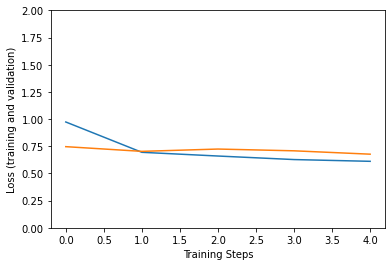

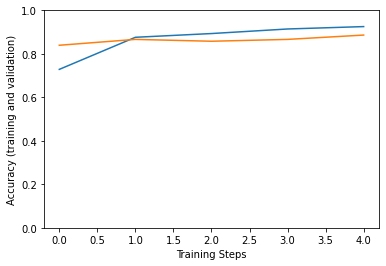

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

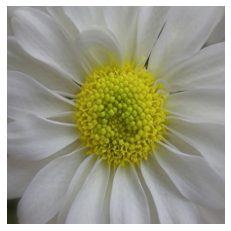

True label: daisy
Predicted label: daisy


In [11]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [12]:
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TF Lite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.

In [13]:
#@title Optimization settings
# docs_infra: no_execute
# TODO(b/156102192)
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("/tmp/lite_flowers_model", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [13]:
# docs_infra: no_execute
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [13]:
#@markdown For rapid experimentation, start with a moderate number of examples.
# docs_infra: no_execute
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))